# Quantum Kernel Method

In this notebook, we will implement examples for the quantum kernel method step-by-step.

## Step 1: Map classical inputs to a quantum problem

* Input: Training dataset
* Output: Abstract circuit for calculating a kernel matrix entry

In this step, data is mapped into the Hilbert state for which we need an encoding method. This is done either by constructing an own circuit or using a pre-made feature map like `zz_feature_map`.

## Step 2: Optimize problem for quantum execution

* Input: Abstract circuit, not optimized for a particular backend
* Output: Target circuit and observable, optimized for the selected QPU

The circuit optimization procedure tries to make the circuit compatible with real quantum computers or to simplify the calculation for simulations. Herefore, we use built-in Qiksit functions, in particular the `generate_preset_pass_manager`. The `optimization_level=3` ensures the highest level of optimization.

## Step 3: Execute using Qiskit Runtime Primitives

* Input: Target circuit
* Output: Probability distribution

The probability distribution can be obtained with Qiskit's `Sampler`, which gives back a quasi-probability distribution.

## Step 4: Post-process, return result in classical format

* Input: Probability distribution
* Output: A single kernel matrix element, or a kernel matrix if repeating

Calculate the probability of measuring $|0\rangle^{\otimes N}$ on the quantum circuit, and populate the kernel matrix in the position corresponding to the two data vectors used. To fill out the entire kernel matrix, we need to run a quantum experiment for each entry. After that, we can use a classical machine learning algorithm that accept pre-calculated kernels, e.g. `qml_svc = SVC(kernel="precomputed")`. Then use the classical workstreams to apply the model to test data, and get an accuracy score.


# Single kernel matrix entry

## Step 1: Map classical input to a quantum problem

Training dataset $\to$ Abstract circuit for calculating a kernel matrix entry

As an example, we use a data set with 10 features. First, look at 2 data points where we remove the labels (last entry). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]
 
# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

For the feature mapping (encoding), let's use the `z_feature_map`:

In [2]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)
 
from qiskit.circuit.library import z_feature_map
 
fm = z_feature_map(feature_dimension=np.shape(train_data)[1])
 
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  9


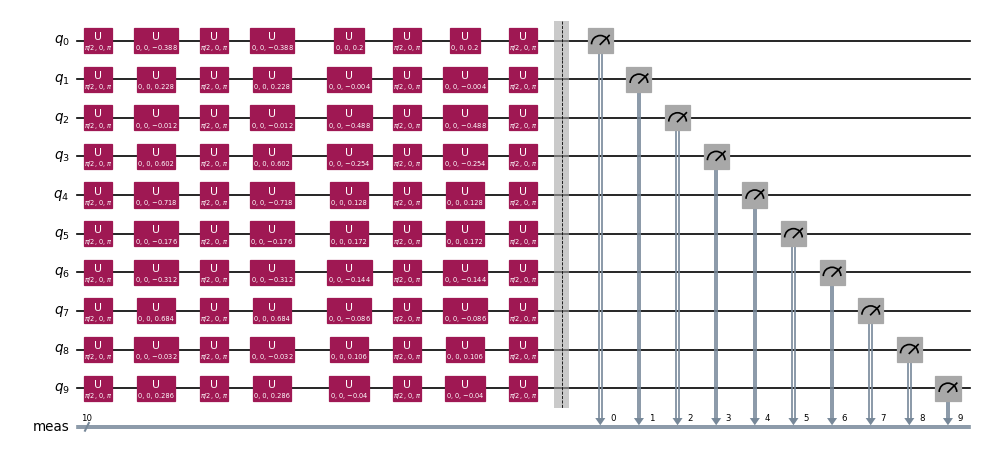

In [3]:
from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

## Step 2: Optimize problem for quantum execution

Run it on least busy backend:

In [4]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

In [5]:
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

management.get:WARNING:2026-02-05 16:06:59,862: Loading default saved account


<IBMBackend('ibm_fez')>


In [6]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

In [7]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)

circuit depth =  10


1

## Step 3: Execute using Qiskit Runtime Primitives

Running on a simulator should only be used to debug scaled-down code (and simple code like this).

In [8]:
# Run this for a simulator
from qiskit.primitives import StatevectorSampler
 
from qiskit_ibm_runtime import Options, Session, Sampler
 
num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

or

In [9]:
# # Import our runtime primitive
# from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
# num_shots = 10000
 
# # Use sampler and get the counts
 
# sampler = Sampler(mode=backend)
# results = sampler.run([overlap_ibm], shots=num_shots).result()
# # .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
# counts_bit = results[0].data.meas.get_counts()
# # .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
# counts = results[0].data.meas.get_int_counts()

## Step 4: Post-process, return result in classical format

The probability of measuring the zero state $|00000\rangle$ is then given by

In [10]:
counts.get(0, 0.0)/num_shots

0.6681

To look at the full distribution of measurement probabilities, we can use `plot_distribution` as

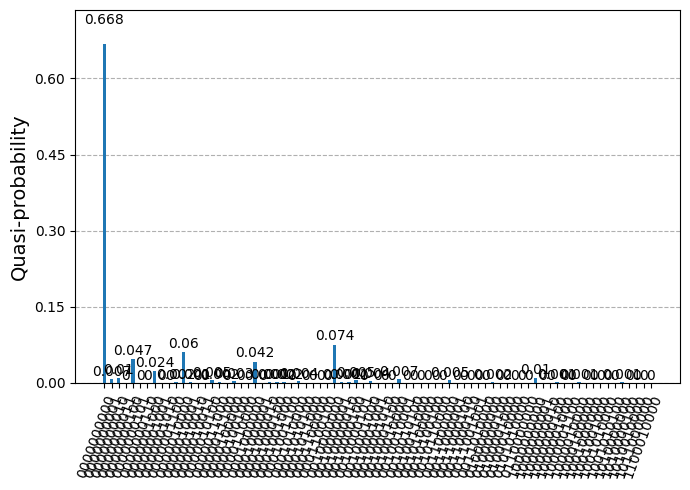

In [11]:
from qiskit.visualization import plot_distribution
 
plot_distribution(counts_bit)

This is not very clear, so let's define a function to pick only the top 10 most probable measurements:

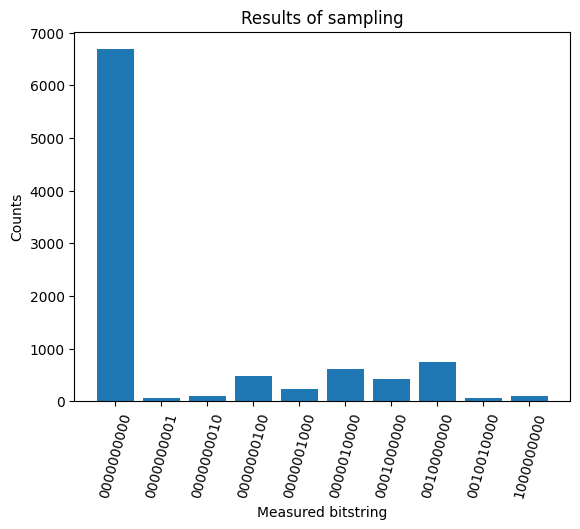

In [12]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()
 
 
visualize_counts(counts, overlap_circ.num_qubits)

# Full kernel matrix

For the extension to a full data set, we need to introduce two new components: 1) classical machine learning in post-processing, 2) accuracy scores for training

## Step 1: Map classical inputs to a quantum problem

First, we need to import a dataset. The one used here consists of 128 data points, with 14 features each. The 15th element indicates the binary category $\pm 1$ (label). We split it into 60 points for the  training set and 30 points for the test set:

In [13]:
#!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
 
df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
 
# Prepare training data
 
train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]
 
# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]

--2026-02-05 16:07:25--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: ‘dataset_graph7.csv.1’

dataset_graph7.csv. 100%[===================>]  48,25K  --.-KB/s    in 0,01s   

2026-02-05 16:07:25 (4,07 MB/s) - ‘dataset_graph7.csv.1’ saved [49405/49405]



Now, construct a kernel matrix and a test matrix of appropriate dimension to store multiple outputs.

In [14]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

Next, we create a feature map. This could be either a built-in map, or our own. This choice should be guided by what we know about the data structure and what feature maps could increase the depth and complexity of the circuit significantly. In this case, we will build our own feature map in the following way:

In [15]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
 
# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

## Step 2 and 3: Optimize problem and execute using primitives

As before, we will create an overlap circuit, and optimize it, just in a different way as before:
* for each pair of data vectors $\vec{x}_i$ and $\vec{x}_j$ create a different overlap circuit
* optimize circuit for each data point pair

The symmetry of a kernel matrix can be leveraged to reduce the number of calculations by 1/2. Diagonals can ideally be send to 1.

In [16]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
 
# Remember to insert your token in the QiskitRuntimeService constructor to use real quantum computers
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )
 
num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

training done
test matrix done


## Step 4: Post-process, return result in classical format

In step 4, we can apply a classical machine learning algorithm to make predictions about our test data and check its accuracy. Therefore, we import Scikit-Learn libraries, in particular the `sklearn.svc`, a support vector classifier (SVC), where we use the precomputed kernel by using `kernel=precomputed`.

In [17]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

By using `SVC.fit, the kernel matrix and the training labels can be fed in to obtain a fit. `SVC.score` will show the result and return our accuracy

In [18]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


It turns out that the accuracy is 100% which is great. But it doesn't show us that we achieved quantum advantage. Likely, a classical ML algorithm would have done the same. We will see later where quantum kernels are most useful. Questions for the reader are:

* How robust is the accuracy? Does it hold for broad types of data or just this specific training data?
* What structure in your dadta makes you suspect that a quantum feature map is useful?
* How is the accuracy affected by increasing/descreasing the amoiunt of training data?
* What feature maps can you use and how do the results vary with feature maps?
* How are the accuracy and running time affected by increasing the number of features?
* Which trends, if any, do you expect to hold on real quantum computers?

# Scaling to more features and qubits

